In [5]:
# Load Libraries

import pytz
import glob as gb
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Add the 'scripts' folder to the Python path
scripts_path = os.path.abspath("../scripts")
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from wrangle import wrangle, merge_monthly_files

## Combining the Datasets


In [58]:
# Define path to the folder where the monthly files are
data_folder = "../data/monthly_p2_readings/"
file_path = os.path.join(data_folder, "*.csv")

# Get all matching csv file paths
csv_files = gb.glob(file_path)

#sort in chronological order
csv_files.sort()

# Apply wrangle to each files and store it in a list
dataframes = []
for file in csv_files:
    try:
        df = wrangle(file)
        dataframes.append(df)
        print(f"Processed {os.path.basename(file)}")
    except Exception as e:
        print(f"Error in Processing {file}: {e}")

# concatenate all cleaned monthly data
combined_df = pd.concat(dataframes)

# Reset index if needed (e.g., for CSV export)
combined_df.reset_index(inplace=False)

# Save to a new CSV
combined_df.to_csv("../data/Air_Quality_Lagos_Combined.csv")

print(f"\nCombined shape: {combined_df.shape}")

Processed 2023_11.csv
Processed 2023_12.csv
Processed 2024_01.csv
Processed 2024_02.csv
Processed 2024_03.csv
Processed 2024_04.csv
Processed 2024_05.csv
Processed 2024_06.csv
Processed 2024_07.csv
Processed 2024_08.csv
Processed 2024_09.csv
Processed 2024_10.csv
Processed 2024_11.csv
Processed 2024_12.csv
Processed 2025_01.csv
Processed 2025_02.csv
Processed 2025_03.csv
Processed 2025_04.csv

Combined shape: (73601, 7)


## Final Exploratory Analysis

In [6]:
# file directory
file= "../data/Air_Quality_Lagos_Combined.csv"

# load into DataFrame
df = pd.read_csv(file, index_col="date", parse_dates=True)

# resampling the data to 1 hour interval
y = df["PM2.5"].resample('6h').mean().interpolate(method = "time")

y.head()

date
2023-11-01 12:00:00+01:00    19.000000
2023-11-01 18:00:00+01:00    15.610000
2023-11-02 00:00:00+01:00    19.867137
2023-11-02 06:00:00+01:00    24.124275
2023-11-02 12:00:00+01:00    28.381412
Freq: 6h, Name: PM2.5, dtype: float64

In [7]:
# Size of the Dataset
shape = y.shape

print(f"The Shape of the Dataset is: {shape}")
print(f"The Dataset has: {shape[0]} historical data")
print(f"The number of missing data is: {y.isna().sum()}")


The Shape of the Dataset is: (2068,)
The Dataset has: 2068 historical data
The number of missing data is: 0


In [61]:
# Range of Data Records
start_date = y.index[0]
end_date = y.index[-1]

print(f"The dataset records is between {start_date} and {end_date}")

The dataset records is between 2023-11-01 12:00:00+01:00 and 2025-04-01 06:00:00+01:00


In [62]:
# Dataset info
print(y.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 2068 entries, 2023-11-01 12:00:00+01:00 to 2025-04-01 06:00:00+01:00
Freq: 6h
Series name: PM2.5
Non-Null Count  Dtype  
--------------  -----  
2068 non-null   float64
dtypes: float64(1)
memory usage: 32.3 KB
None


### Summary

- This Dataset covers for 3 years records.
- Starting from `November 2023` to `April 2025`
- Contains `10902` observations
- There are no missing values in the dataset

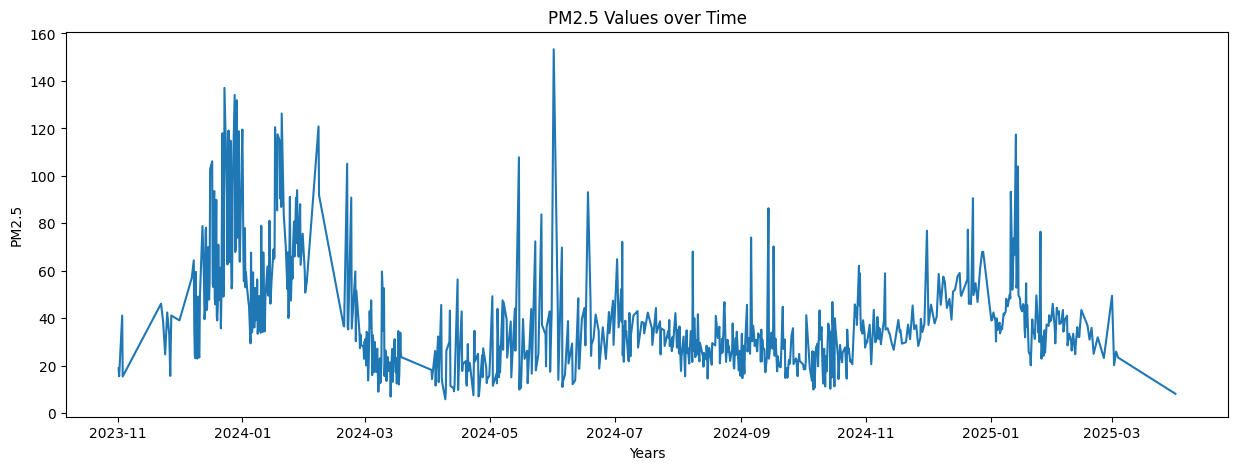

In [65]:
# PM2.5 Over time
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(y)
plt.title("PM2.5 Values over Time")
plt.xlabel("Years")
plt.ylabel("PM2.5")
plt.show()

### Rolling Statistics
- Rolling average
- Rolling Standard deviation

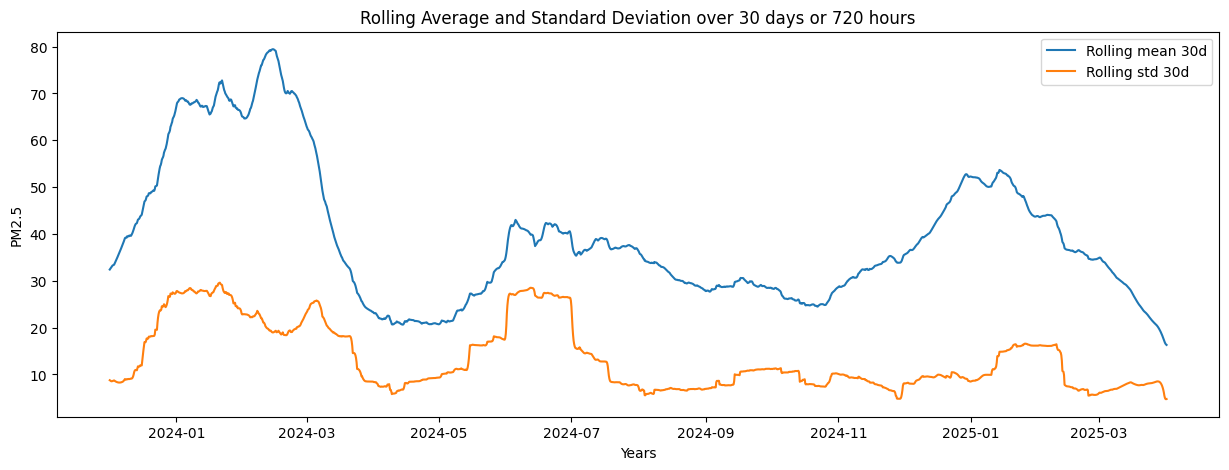

In [66]:
window = 120

# rolling mean for 30 days or 720 hours
rolling_mean = y.rolling(window= window).mean()

# rolling variance for 30 days or 720 hours
rolling_std = y.rolling(window = window).std()

# Plot charts
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(rolling_mean, label = "Rolling mean 30d")
plt.plot(rolling_std, label = "Rolling std 30d")
plt.title("Rolling Average and Standard Deviation over 30 days or 720 hours")
plt.xlabel("Years")
plt.ylabel("PM2.5")

plt.legend()
plt.show()


### Histogram and Boxplot

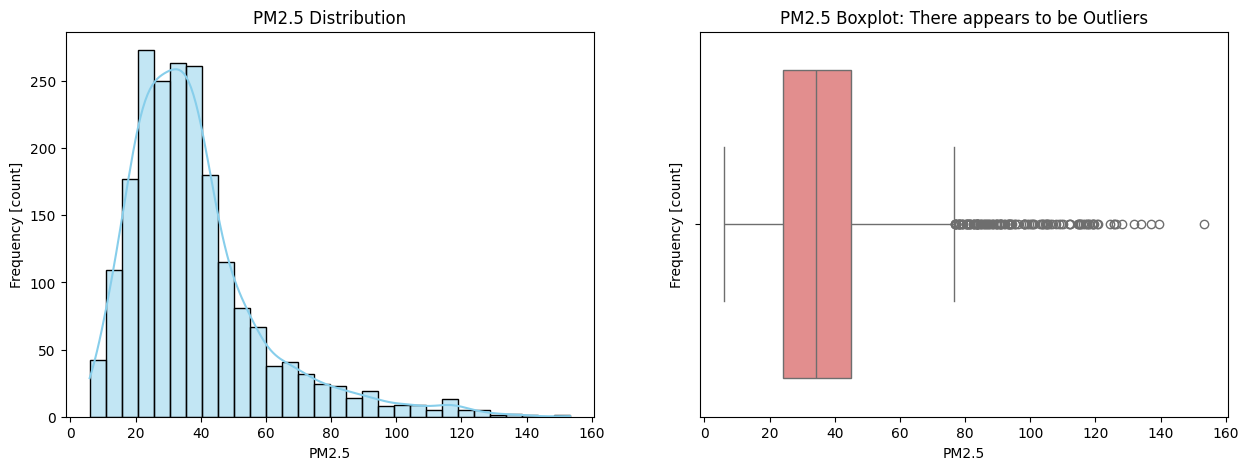

In [67]:
# Figure size
plt.figure(figsize= (15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, bins =  30, color= "skyblue")
plt.title("PM2.5 Distribution")
plt.ylabel("Frequency [count]")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y, color= "lightcoral", orient="h")
plt.title("PM2.5 Boxplot: There appears to be Outliers")
plt.ylabel("Frequency [count]")

plt.show()

### Seasonal Decompose

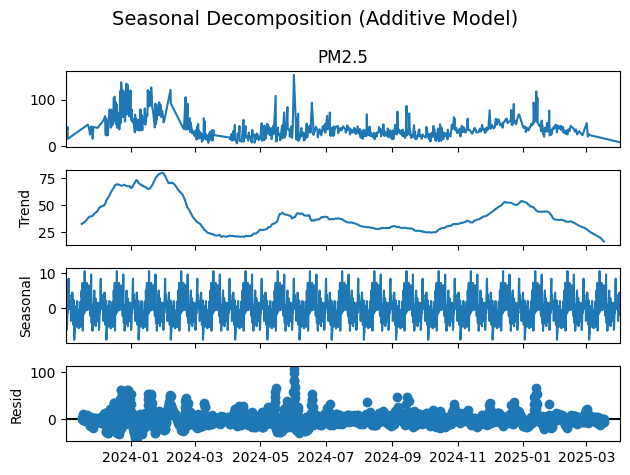

In [68]:
period = 120

# Instantiate the seasonal_decompose
decomposition = seasonal_decompose(y, model="additive", period=period)

# Plot the Chart
decomposition.plot()
plt.suptitle("Seasonal Decomposition (Additive Model)", fontsize=14)
plt.tight_layout()
plt.show()

### ACF and PACF Plots

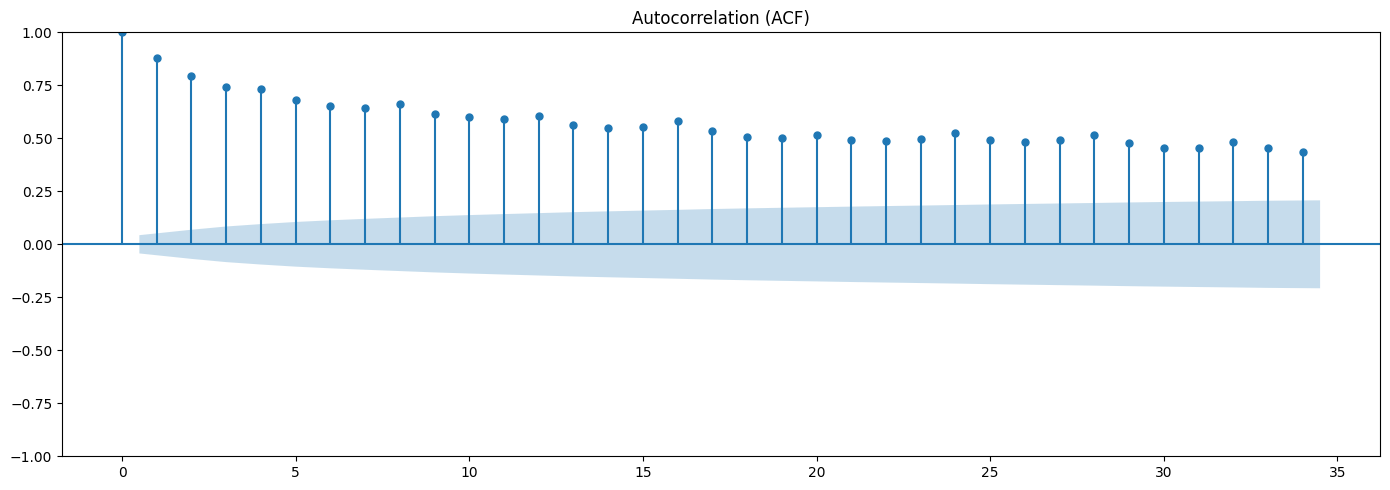

In [80]:
# plot_acf

fig, ax = plt.subplots(figsize=(14, 5))
plot_acf(y, ax=ax)
plt.title("Autocorrelation (ACF)")
plt.tight_layout()
plt.show()

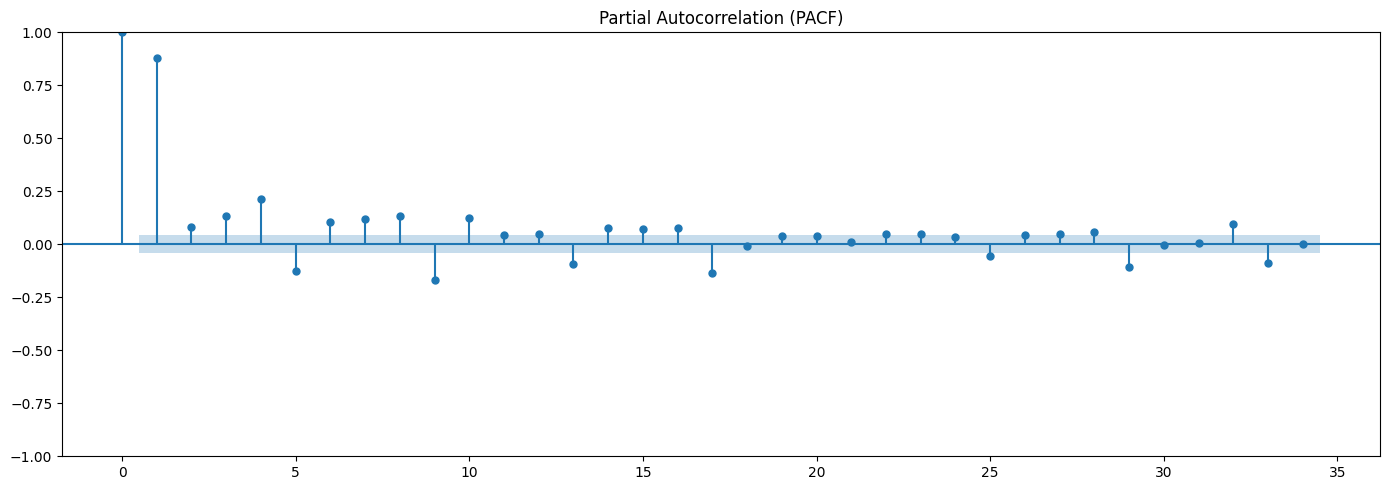

In [71]:
# plot_pacf

fig, ax = plt.subplots(figsize=(14, 5))
plot_pacf(y, ax=ax)
plt.title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()


In [78]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -3.2451190236553566
p-value: 0.017517118874813695


### Summary

- The rolling average and std shows that PM2.5 peaked early 2024, but became more stable over time.
- **Histogram and Boxplot:** The Distribution is right-skewed, typical for pollution data. And we consider Outliers above 400 µg/m³ very extreme. solution: Cap using winsorization or Cap manually
- **Seasonal Decomposition:** There is clear seasonality — possibly monthly cycles due to climate or traffic. meanwhile, Trend is not constant — major spikes and declines.
- **ACF Plot:** Significant autocorrelation persists up to lag ~20. ARMA/ARIMA appears to be a great choice.
- **PACF Plot:** Shows a strong spike at lag 1, Then mostly dies out. This Suggests AR(1) or ARMA(1,q) could be a strong candidate, and beyond lag 1, there is little additional direct predictive value

In [72]:
# 5 Summary Metrics
y.describe()


count    2068.000000
mean       38.215729
std        21.115083
min         5.915768
25%        24.014028
50%        34.101891
75%        45.035161
max       153.364848
Name: PM2.5, dtype: float64

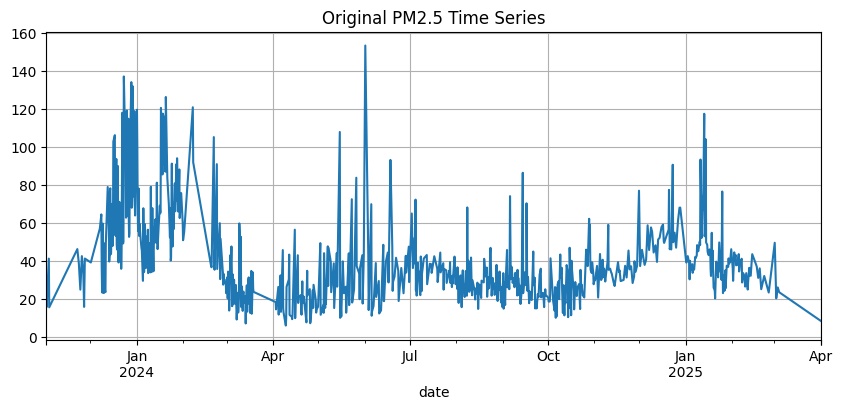

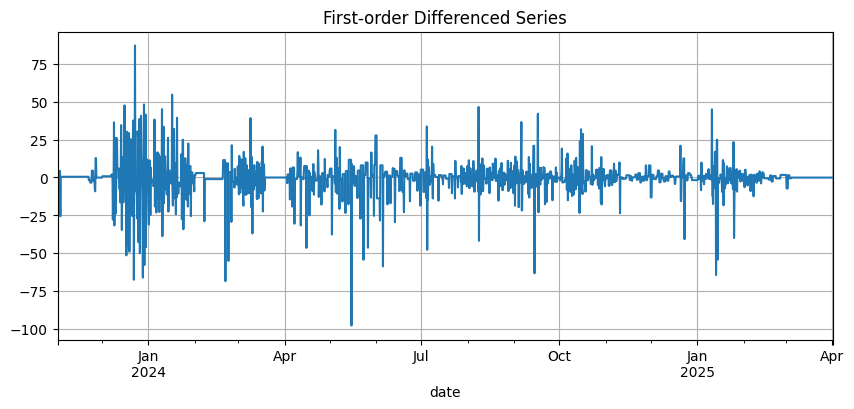

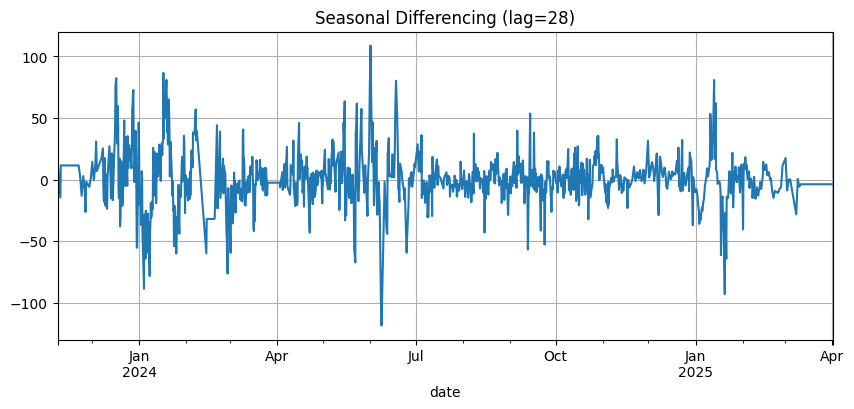

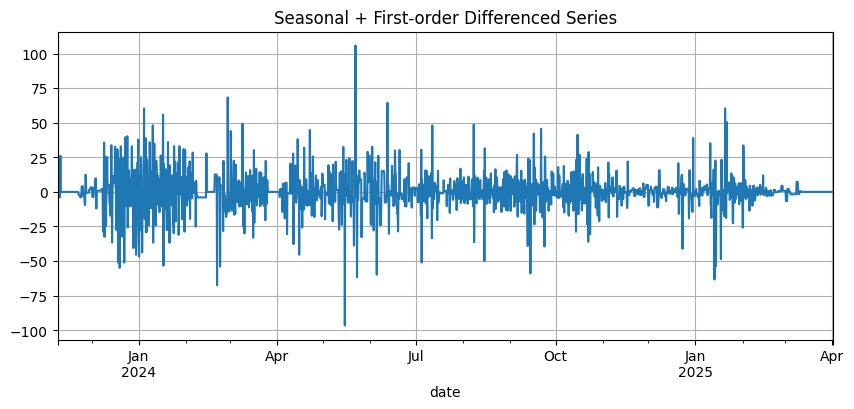

ADF Test: Original Series
ADF Statistic : -3.2451
p-value       : 0.0175
# Lags Used   : 26
# Observations: 2041
Stationary
--------------------------------------------------
ADF Test: First-order Differenced
ADF Statistic : -13.3603
p-value       : 0.0000
# Lags Used   : 26
# Observations: 2040
Stationary
--------------------------------------------------
ADF Test: Seasonal Differenced (lag=28)
ADF Statistic : -12.4107
p-value       : 0.0000
# Lags Used   : 26
# Observations: 2013
Stationary
--------------------------------------------------
ADF Test: Combined Seasonal + First-order Differenced
ADF Statistic : -7.9696
p-value       : 0.0000
# Lags Used   : 26
# Observations: 2012
Stationary
--------------------------------------------------


In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# --- 2. Original PM2.5 Plot
y.plot(title="Original PM2.5 Time Series", figsize=(10, 4))
plt.grid(True)
plt.show()

# --- 3. First-order differencing
y_diff1 = y.diff()
y_diff1.dropna().plot(title="First-order Differenced Series", figsize=(10, 4))
plt.grid(True)
plt.show()

# --- 4. Seasonal differencing (assume weekly seasonality = 4 intervals/day * 7 = 28 lags)
seasonal_lag = 28
y_seasonal_diff = y.diff(seasonal_lag)
y_seasonal_diff.dropna().plot(title=f"Seasonal Differencing (lag={seasonal_lag})", figsize=(10, 4))
plt.grid(True)
plt.show()

# --- 5. Combined differencing (seasonal then first)
y_combined_diff = y.diff(seasonal_lag).diff()
y_combined_diff.dropna().plot(title="Seasonal + First-order Differenced Series", figsize=(10, 4))
plt.grid(True)
plt.show()

# --- 6. ADF Test Function
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test: {title}')
    print(f'ADF Statistic : {result[0]:.4f}')
    print(f'p-value       : {result[1]:.4f}')
    print(f'# Lags Used   : {result[2]}')
    print(f'# Observations: {result[3]}')
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary')
    print('-'*50)

# --- 7. Run ADF tests
adf_test(y, title='Original Series')
adf_test(y_diff1, title='First-order Differenced')
adf_test(y_seasonal_diff, title=f'Seasonal Differenced (lag={seasonal_lag})')
adf_test(y_combined_diff, title='Combined Seasonal + First-order Differenced')
